<a id="contents"></a>

# NOTEBOOK CONTENT

- [**PROJECT SUMMARY**](#summary)


- [**PROJECT PIPELINE**](#workflow)


- [**DATA FOR THE PROJECT**](#data)


- [**EXPLORATORY DATA ANALYSIS**](#eda)


- [**DATA PREPROCESSING**](#preprocess) 


- [**EXTRACT FEATURES.**](#features) 


- [**ITERATIVE K-MEANS CLUSTERING.**](#kmeans) 


- [**SELECT CLUSTER SIZE.**](#clustsize) 


- [**OTHER CLUSTERING METHODS**](#others)


- [**MODEL EVALUATION**](#accuracy)


- [**VISUALIZATION**](#graphs)


- [**OBSERVATIONS**](#obsvs)


- [**CONCLUSION**](#conclude)


- [**REFERENCES**](#references)

In [1]:
!pip install WordCloud
!pip install contractions

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [2]:
#Execute this code to overcome sklearn's memory leaks on Windows.

import os
os.environ["OMP_NUM_THREADS"] = '8'

In [3]:
from time import time
import numpy as np
import pandas as pd
import string
import re
from collections import defaultdict 

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

import matplotlib.pyplot as plt
import seaborn as sns

import contractions
from wordcloud import WordCloud

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kosar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kosar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<a id="summary"></a>

# PROJECT SUMMARY

## Problem statement

The idea is to implement a text similarity mechanism so that when given a large number of documents written in English, the algorithm should be able to group the documents into categories depending on the content of the documents.

This problem of text classiciation can be solved in a variety of ways, based on the information we gathered on the internet. A few examples are as below:    
1. Using some mini-hashing algorithm along with similarity methods (Jaccard, Cosine, etc.)    
2. Using some numerical representation of words followed by feature extraction followed by some dimensionality reduction method followed by an unsupervised clustering algortithm.

**Within the limitations of this course, we have chosen to implement the second method**.

## Project scope.

The goal of the project is to be able to auto-categorize given set of documents in English (e.g., News articles data selected for this project) into groups using unsupervised clustering mechanisms. The idea is to convert the text data into a numerical representation (e.g., Bag-Of-Words, TF-IDF representation, etc), and use k-means clustering algorithm to categorize the documents into clusters. We would then reduce the converted multi-dimensional numerical vectors into manageable number of dimensions (for e.g., 50 dimensions) using Principal Component Analysis for easier visualization.

<a id="workflow"></a>

# PROJECT PIPELINE

<a id="data"></a>

# DATA FOR THE PROJECT

## About the data.

**Source:** http://qwone.com/~jason/20Newsgroups/

The data in the document repositories are in the format of emails sent about some or other specific type of news clippings observed by the email author. I read a comment online saying that the dataset is apparently collected by the Stanford Natrual Language Processing Group over a period of several years.

There are three data sets available:
   - 20news-19997.tar.gz  - Original 20 Newsgroups data set   
   - 20news-bydate.tar.gz - Sorted by date; duplicates and some headers removed (18846 documents)   
   - 20news-18828.tar.gz  - Duplicates removed, only "From" and "Subject" headers (18828 documents)   

The website recommends to use the “20news-bydate” data since some sort of data cleaning is already done, e.g., removal of newsgroup-identifying information removal, etc. And also the data is separated into the train and test sets.

**NOTE:** The dataset is also available from **sklearn** exactly in the same form as the above website except that email headers and footers are removed from the text data of the dataset. I am planning to use this data as I do not see any difference between downloading from "http://qwone.com" or from **sklean**.

The 20 Newsgroups dataset is an aggregation of 18846 newsgroup documents, split evenly across 20 different news groups.
**Topic**    
&emsp; - alt.atheism    
&emsp; - comp.graphics    
&emsp; - comp.os.ms-windows.misc   
&emsp; - comp.sys.ibm.pc.hardware   
&emsp; - comp.sys.mac.hardware   
&emsp; - comp.windows.x   
&emsp; - misc.forsale   
&emsp; - rec.autos   
&emsp; - rec.motorcycles    
&emsp; - rec.sport.baseball    
&emsp; - rec.sport.hockey    
&emsp; - sci.crypt    
&emsp; - sci.electronics    
&emsp; - sci.med    
&emsp; - sci.space    
&emsp; - soc.religion.christian    
&emsp; - talk.politics.guns    
&emsp; - talk.politics.mideast    
&emsp; - talk.politics.misc    
&emsp; - talk.religion.misc    


Based on my observations of the data, I would like to further categorize all of the documents as follows in no particular order:  
  - "politics"  
  - "religion"  
  - "sports and cars"   
  - "computer hardware"   
  - "Misc: electronics, medicine, crpto,etc"   
  - "for sale"

## Download the data

We downloaded the data using the function fetch_20newsgroups provided by the sklearn package. This function allows the user to download the data with the email headers, footers, and quotes which I am going to use.

This extra information, i.e., "headers, footers, etc" if not removed can have an effect of overlapping of data all over the place across multiple dimensions of the feature vector leading to poor classification.

**NOTE:** This stage also involves some data preprocessing. The fetch_20newsgroups is invoked to exclude the header, footer, quotes from each document.

**NOTE:** This stage also involves some data preprocessing. The fetch_20newsgroups is invoked to exclude the header, footer, quotes from each document.

In [5]:
from sklearn.datasets import fetch_20newsgroups

#Download all of the data.
all_data_orig = fetch_20newsgroups(subset='all',
                                   remove=('headers', 'footers', 'quotes'),
                                   shuffle=False)

all_df = pd.DataFrame({'data': all_data_orig.data,
                       'target': all_data_orig.target})

orig_targets_count = len(all_data_orig.target_names)

<a id="eda"></a>
# EXPLORATORY DATA ANALYSIS

## Describe the data

In [6]:
print(all_data_orig.DESCR)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality

In [7]:
print("Total file count: %d" %len(all_data_orig.filenames))
print("File-Target association: " + str(all_data_orig.target))
print("Unique targets: %d" %(len(np.unique(all_data_orig.target))))
print("Predetermined targets: %d" %(len(all_data_orig.target_names)))

Total file count: 18846
File-Target association: [ 9  4 11 ...  4  6  7]
Unique targets: 20
Predetermined targets: 20


In [8]:
all_data_orig.filenames.shape

(18846,)

In [9]:
all_data_orig.target.shape

(18846,)

## Categories of the data
**NOTE:** These were categorized manually by the original data collector.

In [10]:
all_data_orig.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

## Distribution of files among pre-determined groups

### Distribution of files among pre-determined groups (Full dataset).

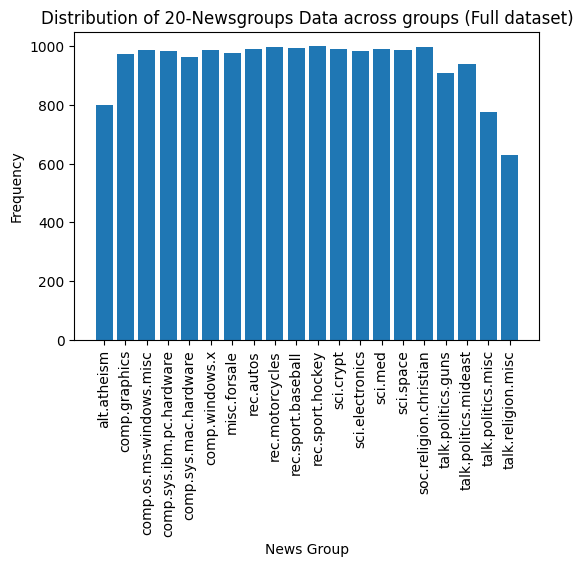

In [11]:
targets, tgt_freq = np.unique(all_data_orig.target, return_counts=True)
target_names = np.array(all_data_orig.target_names)

plt.figure(figsize=(6, 4))
plt.bar(target_names, tgt_freq)
plt.xticks(rotation=90)
plt.title('Distribution of 20-Newsgroups Data across groups (Full dataset)')
plt.xlabel('News Group')
plt.ylabel('Frequency')
plt.show()

**NOTE:** It is evident that all of the categories have moderately balanced number of, aka, substantial imbalance does not exist.

## Sample data

In [12]:
all_df

,data,target
0,\nmorgan and guzman will have era's 1 run high...,9
1,"Well, I just got my Centris 610 yesterday. It...",4
2,Archive-name: cryptography-faq/part10\nLast-mo...,11
3,To the best of my knowledge there aren't any p...,4
4,\n\nI think that domestication will change beh...,0
...,...,...
18841,\nWhy are circuit boards green? The material ...,12
18842,\n\nAnybody who drove into somebody like that ...,8
18843,We were told that the resolution on the 5FGe c...,4
18844,CAD Setup For Sale:\n\nG486PLB Local Bus Mothe...,6


## SAMPLE ANALYSIS OF A DOCUMENT CATEGORY.

## Sample word count.

In [13]:
idx = np.nonzero(all_data_orig.target ==
                 all_data_orig.target_names.index('misc.forsale')
                )[0]

count_vect = CountVectorizer()
doc_matrix = count_vect.fit_transform([all_data_orig.data[i] for i in idx])

rownames = [':'.join(filename.split('/')[-2:])
            for filename in all_data_orig.filenames[idx]]

df = pd.DataFrame.sparse.from_spmatrix(doc_matrix,
                                       columns=count_vect.get_feature_names_out(),
                                       index=rownames)

freq_tab = df.sum(axis=0).astype('int')
freq_tab.nlargest(10)

the    2461
for    1886
and    1802
to     1640
of     1284
00     1175
in     1050
it      895
is      846
you     793
dtype: int32

## Sample Word cloud.

(-0.5, 399.5, 199.5, -0.5)

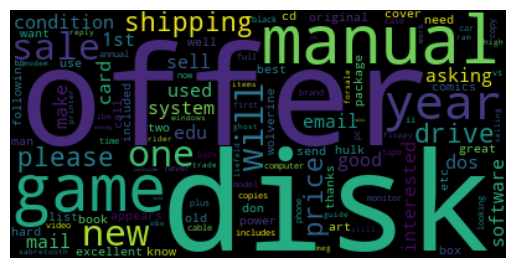

In [14]:
wordcloud = WordCloud().generate(' '.join(freq_tab.nlargest(200).index))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

<a id="preprocess"></a>

# DATA PREPROCESSING

## MISSING DATA, DATA IMBALANCE, DATA SCALING

These categories of data preprocessing is not applicable to my dataset.

## Sample data from a file

In [15]:
all_df.iloc[0][0]

"\nmorgan and guzman will have era's 1 run higher than last year, and\n the cubs will be idiots and not pitch harkey as much as hibbard.\n castillo won't be good (i think he's a stud pitcher)"

**NOTE:** I am going to use this sample data to show how the data is getting transformed at each stage of the preprocessing.

## Lower case
Case sensitiviy do not have any role in document classification. So all of the data will be forced to lower case.

In [16]:
def lower_case(x):
    return re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

all_df['data'] = all_df.data.map(lower_case)
all_df.data[0]

'\nmorgan and guzman will have era s 1 run higher than last year  and\n the cubs will be idiots and not pitch harkey as much as hibbard \n castillo won t be good  i think he s a stud pitcher '

## Remove stop words
The stop words, e.g., conjunctions, etc. are not useful in most of the classification problems. I opine that since we are trying to classify the news articles, the stop words may not add much to the accuracy. I will experiment with removal and non-removal of stop words to test the accuracy.

In [17]:
stop_words = set(stopwords.words('english'))

def remove_stop_words(text_data):
    return ' '.join([word for word in text_data.split() if word not in stop_words])

all_df["data"] = all_df["data"].apply(lambda s: remove_stop_words(s))
all_df.data[0]

'morgan guzman era 1 run higher last year cubs idiots pitch harkey much hibbard castillo good think stud pitcher'

## Remove contractions
Convert words like "can't" into cannot "won't" into "will not". This is to standardize text.
Also this helps to not lose the meaning of words like "won't" after removal of punctuation.

In [18]:
all_df['data'] = all_df["data"].apply(lambda text: contractions.fix(text))
all_df.data[0]

'morgan guzman era 1 run higher last year cubs idiots pitch harkey much hibbard castillo good think stud pitcher'

## Remove punctuation
This can lead to wrong classification depending on the data type that we are trying to classify.    
We chose to remove punctuation.

In [19]:
all_df['data'] = all_df["data"].apply(lambda s: ' '.join(re.sub("[.,!?:;-='...\"@#_]", " ", s).split()))
all_df.data[0]

'morgan guzman era 1 run higher last year cubs idiots pitch harkey much hibbard castillo good think stud pitcher'

## Remove all numbers
I chose to remove numerics as I felt that numbers do not play a role in classification of data.

In [20]:
all_df["data"] = all_df["data"].map(lambda text: re.sub("\d+", '', text))
all_df.data[0]

'morgan guzman era  run higher last year cubs idiots pitch harkey much hibbard castillo good think stud pitcher'

## Remove all strings of size **1**.
**NOTE:** These single letter words may form after removal of puncutation, numbers, etc.

In [21]:
all_df["data"] = all_df["data"].map(lambda text: re.sub(" [a-z] ", ' ', text))
all_df.data[0]

'morgan guzman era  run higher last year cubs idiots pitch harkey much hibbard castillo good think stud pitcher'

## Remove less frequenct words.

In [22]:
from collections import Counter
cnt = Counter()
n_less_freq_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_less_freq_words-1:-1]])

def remove_less_freq_words(text):
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

all_df["data"] = all_df["data"].apply(lambda text: remove_less_freq_words(text))
all_df.data[0]

'morgan guzman era run higher last year cubs idiots pitch harkey much hibbard castillo good think stud pitcher'

## Zipf's law to check on the impact of words based on frequency.

Zipf's law states that the frequency of a token in a text is directly proportional to its rank or position in the sorted list.
This law describes how tokens are distributed in languages: some tokens occur very frequently, some occur with intermediate frequency, and some tokens rarely occur.

When words are ranked according to their frequencies in a large enough collection of texts and then the frequency is plotted against the rank, the result is a logarithmic curve.

The Zipf distribution is used to model situations in which a few observations have a very high value (or impact) and account for a large part of the total, while a very long tail of observations have medium, small, or very small values.

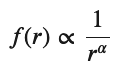

**r** is called the frequency rank of a word, and.   
**f(r)** is its frequency in a natural corpus.

### Plot Zipf's law

Text(0.5, 1.0, "Zipf's law")

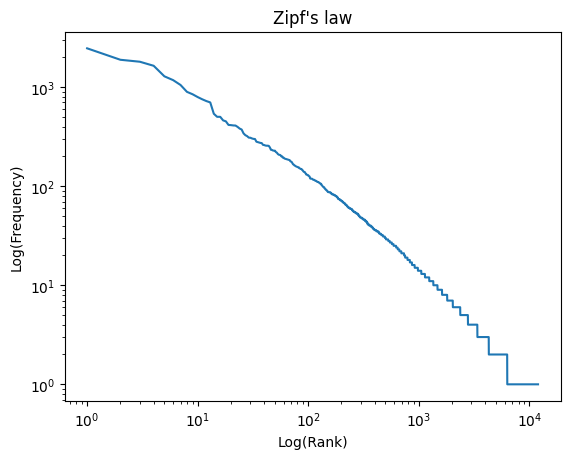

In [23]:
xs = freq_tab.sort_values(ascending=False).reset_index(drop=True, )
plt.loglog(xs.index + 1, xs)
plt.xlabel('Log(Rank)')
plt.ylabel('Log(Frequency)')
plt.title("Zipf's law")

**NOTE:** I did not write any code to achieve this aspect because I have planned to invoke TfidfVectorizer() with **min_df=<count>** which will make the vectorizer to ignore the words that have a frequency LESS THAN OR EUQAL to <count>.

## Lemmatize words    
The goal is to reduce the inflectional forms, and sometimes derivationally related forms of words to a common base word.    
A few examples below:    
  - “fishing”, “fished”, “fisher” will stem to “fish”.    
  - “am”, “are”, will lemmatize to “be”.

In [24]:
tokenizer  = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)])

all_df["data"] = all_df["data"].apply(lemmatize)
all_df.data[0]

'morgan guzman era run higher last year cub idiot pitch harkey much hibbard castillo good think stud pitcher'

<a id="features"></a>

# Extract features using TF-IDF sparse vectorizer.

Text documents are generally nothing but a bunch of words. In order to perform any statistical analysis using computers, the text files are to be converted into numerical format. 

We are going to to use TF-IDF (Term Frequencues Inverse Document Frequency) methodology. The TF-IDF is a statistical methodology that evaluates the relevance of a word to a specific document in a given collection of documents.

Term frequency, tf(t,d), is the relative frequency of term t within document d,    
<font size="4"> $tf(t,d) = $ $\Large \frac{f_{t,d}} {\sum_{t^` \in d} f_{t^`,d}}$</font>.   

where $f_{t,d}$ is the raw count of a term in a document, i.e., the number of times that term t occurs in document d.  

Inverse document frequency is a measure of how much information the word provides if it is common across all of the documents.    
<font size="4">$tf(t,d) = $ $\Large\frac{f_{t,d}} {\sum_{t^` \in d} f_{t^`,d}}$</font>.   
N: Total number of documents in the corpus.    

<font size="4">$|\{d \in D: t \in d\}|$</font>: is the number of documents where the term t appears.

In [25]:
#Parameters to TfidfVectorizer.
# max_df       - Ignore words that appear in more than max_df% of the documents
# min_df       - Ignore words that are not present in at least min_df documents
# sublinear_tf - Replaces 'tf' with '1+log(tf)'. The word that appears more
#                frequently in most documents get weighted less.
# use_idf      - Inverse Document Frequency, which measures how important a term is
# norm         - To reduce the bias of long documents.

tfdif_vec = TfidfVectorizer(sublinear_tf=True,
                            min_df=5, max_df=0.50,
                            stop_words="english")
X = tfdif_vec.fit_transform(all_df.data)
X.shape

(18846, 19480)

# REDUCE DATA DIMENSIONS USING TRUNCATED SVD.

During my experiments, I found that the K-Means was not stable when data with full dimensions is used to train the model.

I did some research and learned that vectorized data can be truncated into lower dimensions using methodologies like Truncated SVD. This methodology is also called as **Latest Semantic Analysis**.

**NOTE:** In the interest of time, I have used binary search and came up with 5000 components that explained the 85% of the variance.

In [26]:
def select_n_components(var_ratios, target_var):
    total_variance = 0.0
    n_components   = 0
    
    for var in var_ratios:
        total_var    += var        
        n_components += 1
        if total_var >= target_var:
            break
    
    return n_components

n_components = 5000
#svd_model = make_pipeline(TruncatedSVD(n_components=X.shape[1]-1), Normalizer(copy=False))
svd_model = make_pipeline(TruncatedSVD(n_components=5000), Normalizer(copy=False))

t0 = time()
X_svd = svd_model.fit_transform(X)

# List of explained variances
svd_var_ratios     = svd_model[0].explained_variance_ratio_
explained_variance = svd_var_ratios.sum()
#n_components = select_n_components(svd_var_ratios, 0.95)

print("TruncatedSVD completed in %s secs" %str(time() - t0))
print(f"Explained variance: %s with %s components" %(str(explained_variance * 100), n_components))

TruncatedSVD completed in 218.78238201141357 secs
Explained variance: 85.68042894123711 with 5000 components


In [27]:
X_svd.shape

(18846, 5000)

# BASELINE K-MEANS MODEL

In [28]:
def generate_analyze_kmeans_model(data, cluster_size):
    measures = defaultdict(list)

    model = KMeans(n_clusters=cluster_size,
                           init='k-means++', #'random'
                           n_init=10, #Single init will reduce time.
                           max_iter=100,
                           verbose=0,
                           random_state=42)
    model.fit(X)
    
    measures["sum_sq_dist"].append(model.inertia_)
    #measures["silhoutte_val"].append(silhouette_score(data, model.labels_, sample_size=3000))
    measures["silhoutte_val"].append(silhouette_score(data, model.labels_))
    
    measures["v_measure"].append(metrics.v_measure_score(all_df.target, model.labels_))
    measures["homogeneity"].append(metrics.homogeneity_score(all_df.target, model.labels_))
    measures["completeness"].append(metrics.completeness_score(all_df.target, model.labels_))
    measures["adj_rand_score"].append(metrics.adjusted_rand_score(all_df.target, model.labels_))

    return model, measures

In [29]:
baseline_kmeans_modelk = 3
baseline_kmeans_model, baseline_measures = generate_analyze_kmeans_model(X,
                                                                         baseline_kmeans_modelk)

<a id="kmeans"></a>

# FINAL K-MEANS MODEL PIPELINE.

In [30]:
def cluster_search_kmeans(data, clust_range,
                          batch, batch_size,
                          verbose):
    
    measures = defaultdict(list)
    
    for nclust in clust_range:
        print("Now checking cluster size: %d" %nclust)
        t0 = time()
        if batch == False:
            model = KMeans(n_clusters=nclust,
                           init="k-means++",
                           #n_init='auto',
                           n_init=10,   #Single init will reduce time.
                           max_iter=100,
                           random_state=42,
                           verbose=verbose)
        else:
            model = MiniBatchKMeans(n_clusters=nclust,
                                    init="k-means++",
                                    #n_init='auto',#Single init will reduce time.
                                    max_iter=100,
                                    init_size=1000,
                                    random_state=42,
                                    batch_size=batch_size,
                                    verbose=verbose)
        
        model.fit(data)
        
        print("Time taken to analyze cluster size-%d: %s" %(nclust, str(time() - t0)))
        
        #measures["silhoutte_val"].append(silhouette_score(data, model.labels_, sample_size=500))
        measures["silhoutte_val"].append(silhouette_score(data, model.labels_))

        measures["sum_sq_dist"].append(model.inertia_)
        measures["v_measure"].append(metrics.v_measure_score(all_df.target, model.labels_))
        measures["homogeneity"].append(metrics.homogeneity_score(all_df.target, model.labels_))
        measures["completeness"].append(metrics.completeness_score(all_df.target, model.labels_))
        measures["adj_rand_score"].append(metrics.adjusted_rand_score(all_df.target, model.labels_))        

    return measures

## K-Means on Original data.

In [31]:
clust_range = range(3, orig_targets_count+1) #[min, max)

t0 = time()
measures_kmeans_orig = cluster_search_kmeans(X,
                                             clust_range,
                                             False,  #Batch k-means
                                             8192,  #Batch size (/8 cores)
                                             verbose=0)
print("Iterative K-Means done in %s secs" %str(time() - t0))

Now checking cluster size: 3
Time taken to analyze cluster size-3: 2.0264642238616943
Now checking cluster size: 4
Time taken to analyze cluster size-4: 2.5145671367645264
Now checking cluster size: 5
Time taken to analyze cluster size-5: 2.929661273956299
Now checking cluster size: 6
Time taken to analyze cluster size-6: 3.5568032264709473
Now checking cluster size: 7
Time taken to analyze cluster size-7: 4.402984380722046
Now checking cluster size: 8
Time taken to analyze cluster size-8: 4.5100181102752686
Now checking cluster size: 9
Time taken to analyze cluster size-9: 5.500241756439209
Now checking cluster size: 10
Time taken to analyze cluster size-10: 5.846320152282715
Now checking cluster size: 11
Time taken to analyze cluster size-11: 4.637042760848999
Now checking cluster size: 12
Time taken to analyze cluster size-12: 4.954126358032227
Now checking cluster size: 13
Time taken to analyze cluster size-13: 6.315425157546997
Now checking cluster size: 14
Time taken to analyze c

## K-Means on TruncatedSVD data.

In [32]:
clust_range = range(3, orig_targets_count+1) #[min, max)

t0 = time()
measures_kmeans_trunc = cluster_search_kmeans(X_svd,
                                              clust_range,
                                              False,  #Batch k-means
                                              8192,  #Batch size (/8 cores)
                                              verbose=0)
print("Iterative K-Means done in %s secs" %str(time() - t0))

Now checking cluster size: 3
Time taken to analyze cluster size-3: 12.55983304977417
Now checking cluster size: 4
Time taken to analyze cluster size-4: 15.975605487823486
Now checking cluster size: 5
Time taken to analyze cluster size-5: 15.811569213867188
Now checking cluster size: 6
Time taken to analyze cluster size-6: 20.91271996498108
Now checking cluster size: 7
Time taken to analyze cluster size-7: 21.735913515090942
Now checking cluster size: 8
Time taken to analyze cluster size-8: 16.26767110824585
Now checking cluster size: 9
Time taken to analyze cluster size-9: 19.32236123085022
Now checking cluster size: 10
Time taken to analyze cluster size-10: 15.257445096969604
Now checking cluster size: 11
Time taken to analyze cluster size-11: 14.031167030334473
Now checking cluster size: 12
Time taken to analyze cluster size-12: 27.013096809387207
Now checking cluster size: 13
Time taken to analyze cluster size-13: 21.699897527694702
Now checking cluster size: 14
Time taken to analyz

In [33]:
dsdsds

NameError: name 'dsdsds' is not defined

<a id="clustsize"></a>

## SELECT CLUSTER SIZE.

### ELBOW METHOD TO SELECT CLUSTER SIZE.

Plot the WCSS values for each cluster size and pick the cluster size at which point the curve seems to have plateued after a steep fall (elbow point).     

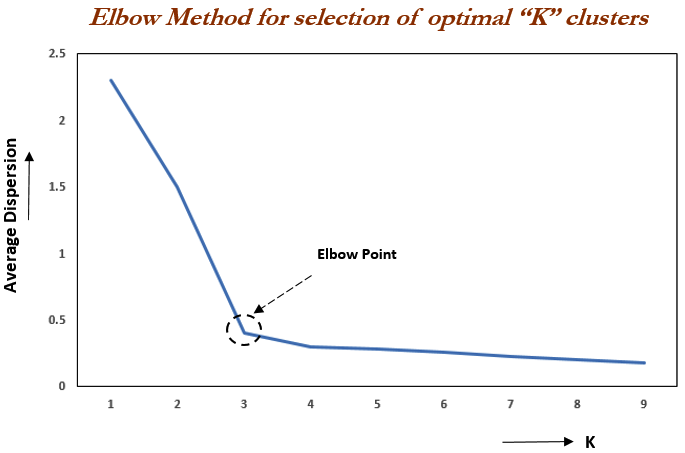    
**NOTE**: This figure is not a representation of actual data of this project. This is just for pictorial represenation of how Elbow method works.

**Source of the image**: "Statistics for Machine Learning by Pratap Dangeti.

### SILHOUTTE SCORE METHOD TO SELECT CLUSTER SIZE.
**NOTE:** If the Elbow method does not give a conclusive guidane on the cluster size to pick, then utilize the Silhoutte score for each data point to determine the optimal cluster size.

**Silhoutte value s(i) for each data point is defined as:**   
<font size="4">$s(i) = \frac{b(i) - a(i)} {\max\{a(i), b(i)\}}$, if $|C_i| > 1 $</font>.   
and   
<font size="4">$s(i) = 0$, if $|C_i| = 1$</font>    


**a(i)** is the measure of similarity of the point i to its own cluster. It is measured as the average distance of i from other points in the cluster.    
For each data point $i \in C_i$ (data point **i** in the cluster $C_i$</font>, let    
<font size="4">$a(i) = \frac{1} {|C_i| - 1} \sum \limits _{j \in C_i , i \neq j} d(i,j)$</font>    


**b(i)** is the measure of dissimilarity of i from points in other clusters.    
<font size="4">$b(i) = \min \limits _{i \neq j} \frac{1} {|C_j|} \sum \limits _{j \in C_j} d(i, j)$</font>

Once the Silhoutte scores are computed for each cluster size, select the cluster size with the highest Silhoutte score.

**Source: Wikipedia**

In [38]:
def plot_wcss(clust_range, sum_sq_distances, tag=""):
    fig,a =  plt.subplots(1,1)
    plt.plot(clust_range,sum_sq_distances)
    plt.title('Sum of squared distance vs. Number of clusters'+tag)
    plt.xlabel('Number of clusters')
    plt.ylabel('Sum of squared distance')
    plt.show()

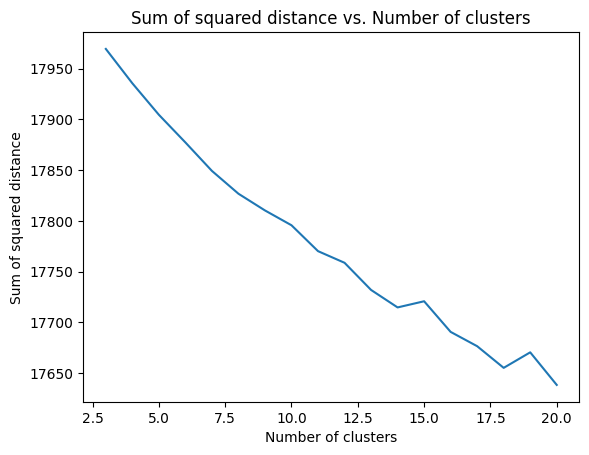

In [39]:
plot_wcss(clust_range, measures_kmeans_orig["sum_sq_dist"])

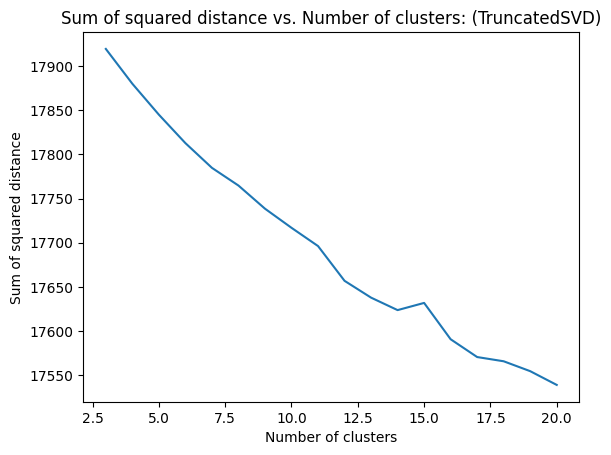

In [41]:
plot_wcss(clust_range, measures_kmeans_trunc["sum_sq_dist"], ": (TruncatedSVD)")

The elbow is visible at 18, but after that the curve is rising. Something is not correct.

**Create a K-Means mode with the cluster size from the elbow point.**

In [42]:
kmeans_model_wcss_k = 14
kmeans_model_wcss, km_measures_wcss = generate_analyze_kmeans_model(X,
                                                                    kmeans_model_wcss_k)

### Verify whether similar cluster size is recommended using the silhoutte score.

In [43]:
def plot_silhoutte(clust_range, silh):
    fig,b =  plt.subplots(1,1)
    plt.plot(clust_range,silh)
    plt.title('Silhoutte score vs. Number of clusters')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhoutte scores')
    plt.show()

**Create a K-Means model with the cluster size associated with highest score (Original data).**

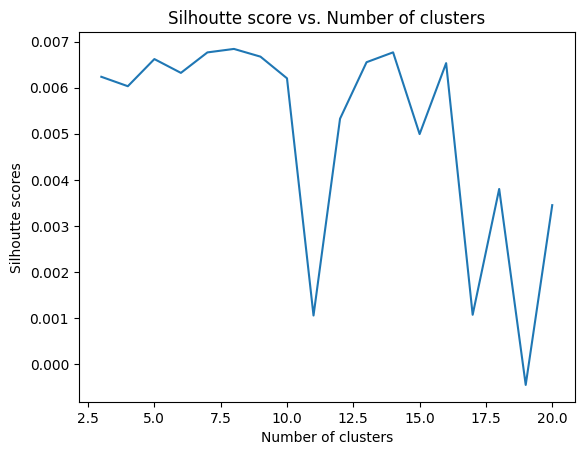

In [44]:
plot_silhoutte(clust_range, measures_kmeans_orig["silhoutte_val"])

In [45]:
kmeans_silh_k = clust_range[0] + np.argmax(measures_kmeans_orig["silhoutte_val"])
print("Cluster size with highest silhoutte score: %d" %(kmeans_silh_k))

Cluster size with highest silhoutte score: 8


In [46]:
kmeans_model_silh, km_measures_silh = generate_analyze_kmeans_model(X,
                                                                    kmeans_silh_k)

**Create a K-Means model with the cluster size associated with highest score (TruncatedSVD).**

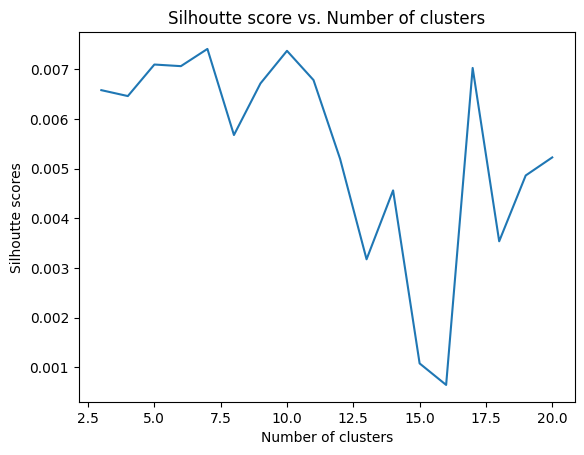

In [47]:
plot_silhoutte(clust_range, measures_kmeans_trunc["silhoutte_val"])

In [48]:
kmeans_silh_trunc_k = clust_range[0] + np.argmax(measures_kmeans_trunc["silhoutte_val"])
print("Cluster size with highest silhoutte score: %d" %(kmeans_silh_trunc_k))

Cluster size with highest silhoutte score: 7


In [49]:
kmeans_model_silh_trunc, km_measures_silh_trunc = generate_analyze_kmeans_model(X,
                                                                                kmeans_silh_trunc_k)

<a id="others"></a>

# OTHER CLUSTERING METHODS

<a id="spectral"></a>

## SPECTRAL CLUSTERING

In [ ]:
from sklearn.cluster import SpectralClustering

def cluster_search_spectral(data, clust_range):
    measures = defaultdict(list)
    
    for nclust in clust_range:
        print("Now checking cluster size: %d" %nclust)
        
        t0 = time()
        clust_model = SpectralClustering(n_clusters=nclust,
                                         affinity='nearest_neighbors',
                                         assign_labels='kmeans',
                                         n_init=10)
        clust_model.fit(data)
        #labels_ = clust_model.fit_predict(data)
        labels_ = clust_model.labels_
        
        print("Time taken to analyze cluster size-%d: %s" %(nclust, str(time() - t0)))
        
        measures["silhoutte_val"].append(silhouette_score(data, labels_))
        measures["v_measure"].append(metrics.v_measure_score(all_df.target, labels_))
        measures["homogeneity"].append(metrics.homogeneity_score(all_df.target, labels_))
        measures["completeness"].append(metrics.completeness_score(all_df.target, labels_))
        measures["adj_rand_score"].append(metrics.adjusted_rand_score(all_df.target, labels_))        

    return measures

clust_range = range(3, orig_targets_count+1) #[min, max)
t0 = time()
measures_spectral = cluster_search_spectral(X, clust_range)
print("Iterative Spectral done in %s secs" %str(time() - t0))

Now checking cluster size: 3
Time taken to analyze cluster size-3: 86.18044781684875
Now checking cluster size: 4


In [ ]:
plot_silhoutte(clust_range, measures_spectral["silhoutte_val"])

In [ ]:
spectral_silh_k = clust_range[0] + np.argmax(measures_spectral["silhoutte_val"])
print("Cluster size with highest silhoutte score: %d" %(spectral_silh_k))

In [ ]:
spectral_model = SpectralClustering(n_clusters=spectral_silh_k,
                                    affinity='nearest_neighbors',
                                    assign_labels='kmeans',
                                    n_init=10)

In [ ]:
spectral_model_measures = measures_spectral[spectral_silh_k]

## AGGLOMERATIVE CLUSTERING

In [ ]:
from sklearn.cluster import AgglomerativeClustering

def cluster_search_agglo(data, clust_range):
    measures = defaultdict(list)
    
    for nclust in clust_range:
        print("Now checking cluster size: %d" %nclust)
        
        t0 = time()
        clust_model = AgglomerativeClustering(n_clusters=nclust)
        clust_model.fit(data.toarray())
        print("Time taken to analyze cluster size-%d: %s" %(nclust, str(time() - t0)))
        
        labels_ = clust_model.labels_
        
        measures["silhoutte_val"].append(silhouette_score(data, labels_))
        measures["v_measure"].append(metrics.v_measure_score(all_df.target, labels_))
        measures["homogeneity"].append(metrics.homogeneity_score(all_df.target, labels_))
        measures["completeness"].append(metrics.completeness_score(all_df.target, labels_))
        measures["adj_rand_score"].append(metrics.adjusted_rand_score(all_df.target, labels_))        

    return measures

clust_range = range(3, orig_targets_count+1) #[min, max)
t0 = time()
measures_agglo = cluster_search_agglo(X, clust_range)
print("Iterative Agglomerative done in %s secs" %str(time() - t0))

In [ ]:
plot_silhoutte(clust_range, measures_agglo["silhoutte_val"])

In [ ]:
agglo_silh_k = clust_range[0] + np.argmax(measures_agglo["silhoutte_val"])
print("Cluster size with highest silhoutte score: %d" %(agglo_silh_k))

In [ ]:
agglo_model = AgglomerativeClustering(n_clusters=nclust)
agglo_model.fit(data.toarray())

In [ ]:
agglo_model_measures = measures_agglo[agglo_silh_k]

<a id="accuracy"></a>

# MODEL EVALUATION

This is not a classification model. So model accuracy is not really relevant.    
But a variety of measures can be displayed.    

**Homogeniety     :** Degree to which clusters contain element of the same class ([0.0,1.0]. 1.0-Best).    
**Completeness    :** Degree to which all elements belonging to certain category are found in a cluster([0,1]. 1-Best).    
**V-measure       :** The mean of homogeniety and completeness ([0.0, 1.0]. 1.0-Best).    
**Silhouette score:** How similar an object is to its own cluster ([-1,1]. 1-Best).    
**Rand score      :** Similarity measure between two clusterings ([0,1]. 1-Identical).

In [ ]:
def show_measures(tag, measures):
    print(tag)
    for name, val in measures.items():
        print("%s, %s" %(name, val))

def abs_func(pct, valCount):
    a  = np.round(pct/100. * valCount.sum(), 0)
    return a
    
def pie_chart(uniqueValues, valCount, title=None, figsize=None):
    labels = ["Cluster "+str(uq) for uq in list(uniqueValues)]

    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie(valCount, explode=None, labels=labels,
                                      autopct=lambda pct: abs_func(pct, valCount),
                                      shadow=True, rotatelabels=True,
                                      startangle = 90)
    ax.axis('equal')  # Aspect ratio
    
    for label, autotext in zip(texts, autotexts):
        autotext.set_rotation(label.get_rotation())
        plt.setp(label, size=7)
    
    if title:
        plt.title(title, loc='right', fontweight=10, rotation=-45)
    plt.setp(autotexts, size=7)
    plt.show()

## Original data.

In [ ]:
# Printing the clusters and number of docs in each clusters.
uniqueValues, valCount = np.unique(all_df.target, return_counts=True)
for n in uniqueValues:
  print("Cluster-%d has %d documents" %(n, valCount[n]))

pie_chart(uniqueValues, valCount, "Original data", figsize=(10, 8))

## BASELINE K-MEANS MODEL.

In [ ]:
show_measures("BASELINE MODEL", baseline_measures)

In [ ]:
# Printing the clusters and number of docs in each clusters.
uniqueValues, valCount = np.unique(baseline_kmeans_model.labels_, return_counts=True)
for n in uniqueValues:
  print("Cluster-%d has %d documents" %(n, valCount[n]))

pie_chart(uniqueValues, valCount, "Baseline model", figsize=(8, 5))

## K-MEANS MODEL SELECTED BY ELBOW METHOD.

### Measures of the Elbow model.

In [ ]:
show_measures("MODEL SELECTED BY ELBOW", km_measures_wcss)

In [ ]:
uniqueValues, valCount = np.unique(kmeans_model_wcss.labels_, return_counts=True)
for n in uniqueValues:
  print("Cluster-%d has %d documents" %(n, valCount[n]))

pie_chart(uniqueValues, valCount, "Model selected by Elbow", figsize=(10, 8))

## K-MEANS MODEL SELECTED USING SILHOUTTE SCORE (Original data).

### Measures of the Silhoutte model.

In [ ]:
show_measures("MODEL SELECTED BY SILHOUTTE SCORE", km_measures_silh)

In [ ]:
uniqueValues, valCount = np.unique(kmeans_model_silh.labels_, return_counts=True)
for n in uniqueValues:
  print("Cluster-%d has %d documents" %(n, valCount[n]))

pie_chart(uniqueValues, valCount,
          "Model selected by Silhoutte score",
          figsize=(8, 5))

## K-MEANS MODEL SELECTED USING SILHOUTTE SCORE (TruncatedSVD).

### Measures of the Silhoutte model.

In [ ]:
show_measures("MODEL SELECTED BY SILHOUTTE SCORE", km_measures_silh_trunc)

In [ ]:
uniqueValues, valCount = np.unique(kmeans_model_silh_trunc.labels_, return_counts=True)
for n in uniqueValues:
  print("Cluster-%d has %d documents" %(n, valCount[n]))

pie_chart(uniqueValues, valCount,
          "Model selected by Silhoutte score",
          figsize=(8, 5))

The measures of the model selected using highest silhoutte score (used as silhoutte-model hereafter) is better than both the baseline model and the model selected using "sum of squared distances".

Based on the available information so far, the final model selected is silhoutte-model.

## SPECTRAL CLUSTERING MODEL

### Measures of the Silhoutte model.

In [ ]:
show_measures("MODEL SELECTED BY SILHOUTTE SCORE", spectral_model_measures)

In [ ]:
uniqueValues, valCount = np.unique(spectral_model.labels_, return_counts=True)
for n in uniqueValues:
  print("Cluster-%d has %d documents" %(n, valCount[n]))

pie_chart(uniqueValues, valCount,
          "Model selected by Silhoutte score",
          figsize=(8, 5))

## AGGLOMERATIVE CLUSTERING MODEL

### Measures of the Silhoutte model.

In [ ]:
show_measures("MODEL SELECTED BY SILHOUTTE SCORE", agglo_model_measures)

In [ ]:
uniqueValues, valCount = np.unique(agglo_model.labels_, return_counts=True)
for n in uniqueValues:
  print("Cluster-%d has %d documents" %(n, valCount[n]))

pie_chart(uniqueValues, valCount,
          "Model selected by Silhoutte score",
          figsize=(8, 5))

<a id="graphs"></a>

# VISUALIZATION

## Visualization of the clusters.

It is not feasible to visualize a plot in more than 3-dimesions.

The idea is to reduce the dimensions of the feature vector from **172641 dimensions** to **2 dimensions** using **Principal Component Analysis** and then use a scatter-plot to show the distribution of the data in reduced dimensions across the clusters.

Even though the dimesnions are reduced, the reduced data is expected to preserve most of the information.

## Use PCA to reduce feature vector dimensions.

In [ ]:
# Init PCA with just 2 components
pcaModel = PCA(n_components=2, random_state=372)

# Fit and transform the data.
pca_data = pcaModel.fit_transform(X.toarray())
#pca_data = pcaModel.fit_transform(X.todense())

#pca_data = pcaModel.fit_transform(X_lsa)

In [ ]:
def plot_pca(labels, pca_data, remap_func):
    visual_df = pd.DataFrame(columns=['cluster_id', 'pca_0', 'pca_1'])
    
    visual_df['cluster_id'] = labels
    visual_df['cluster_id'] = visual_df['cluster_id'].apply(remap_func)
    
    visual_df['pca_0']      = pca_data[:, 0]
    visual_df['pca_1']      = pca_data[:, 1]

    fig = plt.gcf()
    fig.set_size_inches(12, 8)
    sns.scatterplot(data=visual_df,
                    x='pca_0',
                    y='pca_1',
                    hue='cluster_id',
                    palette="viridis").set(title='20news-group clustering')

In [ ]:
def get_top_words(nclusters, topK, model, vectorizer):
    cluster_centers = model.cluster_centers_
    order_centroids = cluster_centers.argsort()[:, ::-1]
    
    if sklearn.__version__ <= "0.24":
        features = vectorizer.get_feature_names()
    else:
        features = vectorizer.get_feature_names_out()
        
    for i in range(nclusters):
        print("Cluster-%d:" % i)
        word_list = []
        for ind in order_centroids[i, :topK]:
            word_list.append(features[ind])
        print(str(word_list))
        print("")

## Visualize "Baseline model" clustering.

### Top words of baseline model.

In [ ]:
get_top_words(baseline_kmeans_modelk, 50, baseline_kmeans_model, tfdif_vec)

By looking at the top words, I can categorize the groups as below:
 - Computers    
 - Games and Auto    
 - Government and Religion

### Visualize classification using pca components.

In [ ]:
def remap_baseline(class_type):
    if class_type == 0:
        return "Computers"
    elif class_type == 1:
        return "Games and Auto   "
    else:
        return "Government and Religionn"

plot_pca(baseline_kmeans_model.labels_, pca_data, remap_baseline)

## Visualize clusters of K-Means model selected by WCSS score.

### Top words of model selected by Silhoutte score.

In [ ]:
get_top_words(kmeans_model_silh_k, 50, kmeans_model_silh, tfdif_vec)

### Visualize classification using pca components.

In [ ]:
def remap_silhoutte(class_type):
    if class_type == 0:
        return "Auto"
    elif class_type == 1:
        return "Religion"
    elif class_type == 2:
        return "Government"
    elif class_type == 3:
        return "Unspecific"
    elif class_type == 4:
        return "Medicine"
    elif class_type == 5:
        return "Game"
    elif class_type == 6:
        return "Computer Software"
    elif class_type == 7:
        return "Computer Hardware"

plot_pca(kmeans_model_silh.labels_, pca_data, remap_silhoutte)

## Visualize clusters of K-Means model selected by silhoutte score.

### Top words of model selected by Silhoutte score.

In [ ]:
get_top_words(kmeans_model_silh_k, 50, kmeans_model_silh, tfdif_vec)

By looking at the top words, I can categorize the groups as below:
 - Cluster-0: Auto   
 - Cluster-1: Religion    
 - Cluster-2: Government    
 - Cluster-3: Unspecific-1    
 - Cluster-4: Medicine    
 - Cluster-5: Game    
 - Cluster-6: Computer Software    
 - Cluster-7: Computer Hardware

### Visualize classification using pca components.

In [ ]:
def remap_silhoutte(class_type):
    if class_type == 0:
        return "Auto"
    elif class_type == 1:
        return "Religion"
    elif class_type == 2:
        return "Government"
    elif class_type == 3:
        return "Unspecific"
    elif class_type == 4:
        return "Medicine"
    elif class_type == 5:
        return "Game"
    elif class_type == 6:
        return "Computer Software"
    elif class_type == 7:
        return "Computer Hardware"

plot_pca(kmeans_model_silh.labels_, pca_data, remap_silhoutte)

## Visualize spectral model clustering

### Top words of model selected by Silhoutte score.

In [ ]:
get_top_words(spectral_model_k, 50, spectral_model, tfdif_vec)

### Visualize classification using pca components.

## Visualize Agglomerative model clustering

### Visualize classification using pca components.

In [ ]:
get_top_words(agglo_model_k, 50, agglo_model, tfdif_vec)

### Visualize classification using pca components.

<a id="obsvs"></a>

# OBSERVATIONS

The measures of both the elbow model and the silhoutte model are leaps and bounds better than the baseline model.

The "sum of squared distances" plot is showing an elbow. But the "sum of squared distances" after that started to rise rapidly. This is not supposed to happen. I need to investigate more on this aspect. Perhaps Elbow method is not suitable for the dataset I chose!

The knn model selected using higher silhoutte score is way better than the "method selected by elbow identification" because there are less overlaps among the clusters.

The distribution of documents across clusters is imbalanced. I will try to refine the data and the model before the final submission.

Referring to the "About Data" section again,

The visual inspection of the document categories appears to be as follows in no particular order:  
  - "politics"  
  - "religion"  
  - "sports and cars"  
  - "computer hardware"  
  - "Misc: electronics, medicine, crpto,etc"  
  - "for sale"  
  
In general, notice that documents under "computer hardware" and "Misc" categories will have a heavy overlap.

Also "Misc" and "For sale" can also have an overlap.

**NOTE:** Trying to curve fit to achieve the same **6 categories** as above is not a correct approach.

## Observations on the cluster-size "3"

Based on the keywords in each category for **cluster size of 3**, I could infer that the implementation has categorized the documents as follows:  
  - "politics and religion"  
  - "sports and cars"  
  - "Everything else: computer hardware, electronics, medicine, cryptos, etc."   

In a theoritical sense the classification is **resonably correct**. But there are overlaps between the clusters as shown in the scatter-plot above, especially between the "technology" and "sports and cars" categories. This overlap can be explained because there are definitely commond words used among the texts of different categories, which when transformed into TF-IDF vectorization may lead to similarities in some of the feature dimensions.  

## Observations on cluster-size "11".

Based on the keywords in each category for **cluster size of 3**, I could infer that the implementation has categorized the documents as follows:  
  - "politics and religion"  
  - "sports and cars"  
  - "Everything else: computer hardware, electronics, medicine, cryptos, etc."   

In a theoritical sense the classification is **resonably correct**. But there are overlaps between the clusters as shown in the scatter-plot above, especially between the "technology" and "sports and cars" categories. This overlap can be explained because there are definitely commond words used among the texts of different categories, which when transformed into TF-IDF vectorization may lead to similarities in some of the feature dimensions.  

## Some pitfalls observed.

**unigram vs n-gram**
Words like ["Ram", "car"] are considered as unigrams. An n-gram represents **n** number of words as one single entity, e.g., "bus has", etc. 

Instead of using unigrams, a bigram, trigram, or some n-gram might be able to provide much better classification.

<a id="conclude"></a>

# CONCLUSION

It is been demonstrated in this project that using a combination of TF-IDF feature vector generation, and k-means clustering, a given bunch of text documents in English can be classified into meaningful groups via unsupervised learning without having any labled data as a reference.

<a id="references"></a>

# REFERENCES

Wikipedia